In [121]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [122]:
init_lr = 1e-3
epochs = 25
batch_size = 8

In [123]:
import pandas as pd 
df = pd.read_csv('metadata.csv') 
df.head()
df.columns

Index([u'patientid', u'offset', u'sex', u'age', u'finding', u'survival',
       u'temperature', u'pO2 saturation', u'leukocyte count',
       u'neutrophil count', u'lymphocyte count', u'view', u'modality', u'date',
       u'location', u'folder', u'filename', u'doi', u' url', u'license',
       u'clinical notes', u'other notes', u'Unnamed: 22'],
      dtype='object')

In [124]:
fol=df["folder"].astype(str)
filename=df["filename"].astype(str)
y=df["finding"].astype(str)
y

0            COVID-19
1            COVID-19
2            COVID-19
3            COVID-19
4            COVID-19
5            COVID-19
6                ARDS
7            COVID-19
8            COVID-19
9                SARS
10               SARS
11               SARS
12               SARS
13               SARS
14               SARS
15               SARS
16               SARS
17               SARS
18               SARS
19               SARS
20           COVID-19
21           COVID-19
22           COVID-19
23           COVID-19
24           COVID-19
25           COVID-19
26           COVID-19
27           COVID-19
28           COVID-19
29           COVID-19
            ...      
218          COVID-19
219          COVID-19
220          COVID-19
221          COVID-19
222          COVID-19
223          COVID-19
224    COVID-19, ARDS
225          COVID-19
226          COVID-19
227          COVID-19
228          COVID-19
229          COVID-19
230          COVID-19
231          COVID-19
232       

In [125]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

data=[]
labels=[]
#dim=(500,500)

for i in range(len(fol)):
    if fol[i]=='images':
        path=os.path.join(fol[i],filename[i])
        img=cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = cv2.resize(img, (224, 224))
    
        label = y[i]
        
        data.append(image)
        labels.append(label)


In [126]:
labels=[1 if i == 'COVID-19' else 0 for i in labels]
data = np.array(data) / 255.0
labels = np.array(labels)
print(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels)

[1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.

In [127]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [128]:
baseModel = VGG16(weights="vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)
model.load_weights('Hmodel.h5')

for layer in baseModel.layers:
    layer.trainable = False

In [11]:
print("compiling model...")
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


print("training head...")
H = model.fit_generator(
    trainAug.flow(data, labels, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=5)

compiling model...
training head...
Epoch 1/5
22/22 [==============================] - 40s 2s/step - loss: 0.5362 - acc: 0.7122 - val_loss: 0.5743 - val_acc: 0.7391
Epoch 2/5
22/22 [==============================] - 45s 2s/step - loss: 0.4316 - acc: 0.8239 - val_loss: 0.5890 - val_acc: 0.7391
Epoch 3/5
22/22 [==============================] - 44s 2s/step - loss: 0.5214 - acc: 0.7326 - val_loss: 0.5602 - val_acc: 0.7826
Epoch 4/5
22/22 [==============================] - 44s 2s/step - loss: 0.4766 - acc: 0.7611 - val_loss: 0.5752 - val_acc: 0.7391
Epoch 5/5
22/22 [==============================] - 45s 2s/step - loss: 0.4940 - acc: 0.8011 - val_loss: 0.5456 - val_acc: 0.7609


In [129]:
filename = 'Hmodel.h5'
model.save_weights(filename)

In [130]:
filename='MModel.h5'
model.save(filename)

In [136]:
from keras.models import load_model

loaded_model=load_model('MModel.h5')
loaded_model.predict(testX)

array([[0.4484777 , 0.5515224 ],
       [0.50304145, 0.49695864],
       [0.49128523, 0.50871474],
       [0.57842   , 0.42158002],
       [0.00261651, 0.99738353],
       [0.5419066 , 0.45809346],
       [0.02306286, 0.9769372 ],
       [0.08851339, 0.91148657],
       [0.26117247, 0.7388275 ],
       [0.01897238, 0.9810276 ],
       [0.44887   , 0.55113006],
       [0.467275  , 0.532725  ],
       [0.19214375, 0.80785626],
       [0.31566274, 0.6843373 ],
       [0.36038417, 0.63961583],
       [0.51073825, 0.48926172],
       [0.06352919, 0.93647087],
       [0.16279256, 0.8372075 ],
       [0.50597924, 0.49402073],
       [0.46330646, 0.5366935 ],
       [0.27389556, 0.7261045 ],
       [0.39774087, 0.60225916],
       [0.26169837, 0.73830163],
       [0.17508154, 0.82491845],
       [0.60690916, 0.39309084],
       [0.13506989, 0.86493015],
       [0.33748716, 0.66251284],
       [0.5167334 , 0.48326653],
       [0.31928605, 0.680714  ],
       [0.39177728, 0.6082227 ],
       [0.

In [137]:
from lime import lime_image

In [138]:
explainer = lime_image.LimeImageExplainer()
i=45

In [139]:
explanation = explainer.explain_instance(testX[i], loaded_model.predict, 
                                         top_labels=2, hide_color=0, 
                                         num_samples=200)

100% |########################################################################|


In [140]:
from skimage.segmentation import mark_boundaries

In [141]:
pred=loaded_model.predict(testX)
print(pred[i])
print(testY[i])

[0.04639148 0.9536085 ]
[0. 1.]


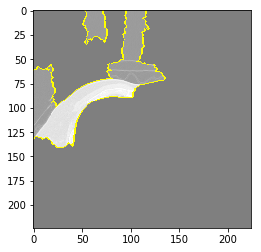

In [142]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

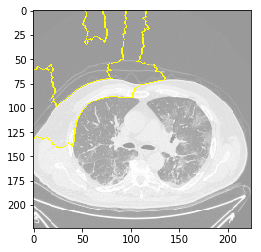

In [143]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

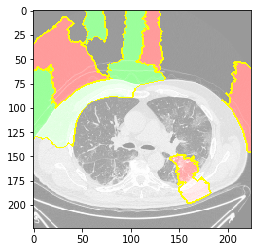

In [144]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


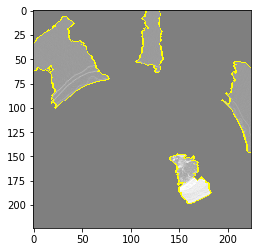

In [145]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [146]:
Xray_out=loaded_model.predict(data)

In [147]:
Xray_out

array([[0.36534747, 0.63465255],
       [0.21880157, 0.78119844],
       [0.4086143 , 0.5913857 ],
       [0.26919636, 0.7308036 ],
       [0.36304694, 0.63695306],
       [0.24954823, 0.75045174],
       [0.49093527, 0.5090648 ],
       [0.23856053, 0.76143944],
       [0.21838744, 0.7816125 ],
       [0.48314592, 0.5168541 ],
       [0.41995078, 0.5800492 ],
       [0.51014185, 0.48985815],
       [0.5517085 , 0.4482915 ],
       [0.467275  , 0.532725  ],
       [0.48013318, 0.51986676],
       [0.54083896, 0.45916104],
       [0.5687177 , 0.4312823 ],
       [0.61249155, 0.38750842],
       [0.5765644 , 0.42343563],
       [0.50520825, 0.49479178],
       [0.33481184, 0.66518813],
       [0.15075667, 0.8492433 ],
       [0.3694022 , 0.63059783],
       [0.24344762, 0.75655246],
       [0.3102677 , 0.68973225],
       [0.11683652, 0.88316345],
       [0.42619532, 0.5738047 ],
       [0.361869  , 0.638131  ],
       [0.18441708, 0.81558293],
       [0.16917741, 0.8308226 ],
       [0.

In [148]:
from sklearn.preprocessing import LabelEncoder 
df=df.fillna(df.mean())
le = LabelEncoder() 

sex=df["sex"].astype(str)  
sex= le.fit_transform(sex) 


cli=df["clinical notes"].astype(str)
cli= le.fit_transform(cli) 

other=df["other notes"].astype(str)
other= le.fit_transform(other) 

temp=df["temperature"].astype(float)


df["pO2 saturation"].fillna(df["pO2 saturation"].mean())
po2=df["pO2 saturation"].astype(float)

df["leukocyte count"].fillna(df["leukocyte count"].mean())
leu=df["leukocyte count"].astype(float)

df["neutrophil count"].fillna(df["neutrophil count"].mean())
neu=df["neutrophil count"].astype(float)


df["lymphocyte count"].fillna(df["lymphocyte count"].mean())
lym=df["lymphocyte count"].astype(float)

In [149]:
a=[]
b=[]
c=[]
d=[]
e=[]
f=[]
g=[]
h=[]

for i in range(len(fol)):
    if fol[i]=='images':
        a.append(sex[i])
        b.append(cli[i])
        c.append(other[i])
        d.append(temp[i])
        e.append(po2)
        f.append(leu)
        g.append(neu)
        h.append(lym)
        
a=np.asarray(a)
b=np.asarray(b)
c=np.asarray(c)
d=np.asarray(d)
e=np.asarray(e)
f=np.asarray(f)
g=np.asarray(g)
h=np.asarray(h)
x=Xray_out.transpose()
x1=x[0]
x2=x[1]
list(x1)
list(x2)

[0.63465255,
 0.78119844,
 0.5913857,
 0.7308036,
 0.63695306,
 0.75045174,
 0.5090648,
 0.76143944,
 0.7816125,
 0.5168541,
 0.5800492,
 0.48985815,
 0.4482915,
 0.532725,
 0.51986676,
 0.45916104,
 0.4312823,
 0.38750842,
 0.42343563,
 0.49479178,
 0.66518813,
 0.8492433,
 0.63059783,
 0.75655246,
 0.68973225,
 0.88316345,
 0.5738047,
 0.638131,
 0.81558293,
 0.8308226,
 0.75340426,
 0.78136516,
 0.86493015,
 0.45809346,
 0.74205774,
 0.6162998,
 0.7684715,
 0.99662906,
 0.9986272,
 0.69352865,
 0.7999532,
 0.56233853,
 0.6939803,
 0.7284458,
 0.98671967,
 0.9907946,
 0.9741189,
 0.9920622,
 0.70808816,
 0.8372075,
 0.7602883,
 0.768842,
 0.55012906,
 0.6117107,
 0.66110414,
 0.67859995,
 0.4458572,
 0.70489997,
 0.40543112,
 0.2310677,
 0.66985023,
 0.4984946,
 0.36610478,
 0.50871474,
 0.3849543,
 0.44396073,
 0.426516,
 0.6818725,
 0.9925938,
 0.9956475,
 0.5578392,
 0.60225916,
 0.9931914,
 0.6977265,
 0.99536043,
 0.99738353,
 0.6022299,
 0.992081,
 0.9893411,
 0.631602,
 0.7261

In [150]:
x=np.column_stack((a,d,e,f,g,h,x1,x2))

In [151]:
import pandas as pd

In [152]:
(x_train, x_test, y_train, y_test) = train_test_split(x, labels,
    test_size=0.20, stratify=labels, random_state=42)
x_test.shape

(46, 996)

In [153]:
import sklearn.ensemble
import pickle

loaded_model = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
loaded_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [154]:
result = loaded_model.score(x_test, y_test)
print(result)
filename = 'RF.sav'
pickle.dump(loaded_model, open(filename, 'wb'))
filename = 'RF.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.782608695652174
0.782608695652174
